RNN multiple features
weather history data

In [1]:
###-----------------
### Import Libraries
###-----------------
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error

import tensorflow as tf
# from utils.helper import fn_plot_tf_hist

In [2]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [3]:
### ----------------------
### global variables
### ----------------------

import random

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


TEST_SIZE = 0.2
ALPHA = 0.001 # LEARNING RATE
EPOCHS = 75  # NUMBER OF ITERATIONS
BATCH_SIZE = 64                 # Default for Tensorflow

# input and output directories
inpDir = '../../input'
outDir = '../output'

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
}

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

# Load Shakespeare Data

In [10]:
fileName = 'shakespeare.txt'
filepath = os.path.join(os.getcwd(), fileName)
filepath

'/content/shakespeare.txt'

In [11]:
text = open(filepath, 'rb').read().decode(encoding = 'utf-8')
len(text)

1115395

In [12]:
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [13]:
# Char based modeling

In [14]:
vocab = sorted(set(text))
len(vocab)

65

In [15]:
char2idx = {u : i for i, u in enumerate(vocab)}
idx2char = np.array(vocab) # in array i can refer element by idx

In [16]:
text_as_int = np.array([char2idx[c] for c in text])
text_as_int

array([18, 47, 56, ...,  8,  0,  0])

In [17]:
type(text_as_int)

numpy.ndarray

In [18]:
seq_length = 100
example_per_epoch = len(text) // (seq_length + 1)
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(20):
    print(i.numpy(), end = " : " )
    print(idx2char[i.numpy()])
    print

18 : F
47 : i
56 : r
57 : s
58 : t
1 :  
15 : C
47 : i
58 : t
47 : i
64 : z
43 : e
52 : n
10 : :
0 : 

14 : B
43 : e
44 : f
53 : o
56 : r


In [19]:
sequences = char_dataset.batch(seq_length + 1, drop_remainder= True)

for item in sequences.take(1):
    print(item)
    print(repr("".join(idx2char[item.numpy()])))

tf.Tensor(
[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59  1], shape=(101,), dtype=int64)
'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [20]:
def split_input_target(chunk):
    input_text = chunk[:-1]     # first hundred characters
    target_text = chunk[1:]     # offset one as target
    return input_text, target_text

dataset = sequences.map(split_input_target)


In [21]:
for inp_ex, tar_ex in dataset.take(1):
    print(repr("".join(idx2char[inp_ex.numpy()])))
    print(repr("".join(idx2char[tar_ex.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [22]:
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,
                                            drop_remainder = True)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [23]:
vocab_size = len(vocab)
embedding_dim = 256
rnn_units = 1024

In [48]:
def build_model(vocab_size,
                embedding_dim,
                rnn_units,
                batch_size = BATCH_SIZE):

    return tf.keras.Sequential([
        tf.keras.layers.Input(shape = (None, ),
                              batch_size = batch_size),
        tf.keras.layers.Embedding(vocab_size,
                                  embedding_dim),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences = True,
                            stateful = True,
                            recurrent_initializer = "glorot_uniform"),
        tf.keras.layers.Dense(vocab_size)
    ])



In [49]:
model = build_model(vocab_size, embedding_dim, rnn_units)


In [50]:
# Unit testing. Check for model's health without training
for inp_ex, tar_ex in dataset.take(1):
    ex_pred = model(inp_ex)

In [51]:
len(ex_pred)

64

In [52]:
# why we sample

sample_indices = tf.random.categorical(ex_pred[0], num_samples = 1)
print(sample_indices.shape)

(100, 1)


In [53]:
sample_indices = tf.squeeze(sample_indices, axis = -1).numpy()
sample_indices.shape

(100,)

In [54]:
display(sample_indices)


array([14,  1, 27, 46, 28, 51,  2, 50, 17, 30, 27, 34,  6, 64, 63, 14, 32,
       10,  9, 21, 33, 12,  8, 33, 35, 47, 17,  8,  1, 10, 10, 11, 26, 24,
        6,  9,  1, 45, 25, 62, 21, 12, 20,  5, 62, 62,  0, 50, 18, 56, 37,
       63,  6, 20, 62, 34, 47, 56, 41, 12, 18, 17, 12, 46,  6, 64, 26, 22,
       18, 37, 59,  3, 42, 46, 46, 51, 51, 48, 19,  5,  3, 16, 32, 21, 22,
       16, 31, 24, 40, 40, 34, 33, 59, 11,  9, 44, 49, 29, 49, 18])

In [55]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits = True)

In [56]:
model.compile(optimizer = "adam",
              loss = loss_fn,
              metrics = ['accuracy'])

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
chkPtPath = os.path.join(os.getcwd())
chkPtPrefix = os.path.join(chkPtPath, "/content/chkpts/chkpt_{epoch}.keras")
chkpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath = chkPtPrefix)

/content/shakespeare.txt

In [36]:
# Make sure to run cell below on T4 TPU

In [ ]:
history = model.fit(dataset,
                    epochs = EPOCHS,
                    callbacks = [chkpt_callback],
                    verbose = 1)

Epoch 1/75
 71/172 ━━━━━━━━━━━━━━━━━━━━ 11:05 7s/step - accuracy: 0.1828 - loss: 3.6026

In [ ]:
loss_df = pd.DataFrame(history.history)


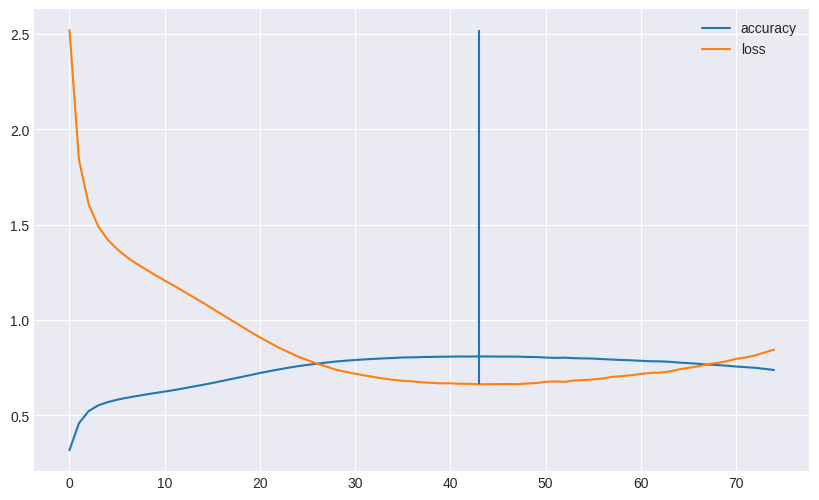

In [ ]:
ax = loss_df.plot()
ax.vlines(loss_df.loc[loss_df["loss"] == loss_df["loss"].min()].index,
          ymin = loss_df.loc[loss_df["loss"] == loss_df["loss"].min()].values[0][1],
          ymax = loss_df.loc[loss_df["loss"] == loss_df["loss"].max()].values[0][1],
          )

In [ ]:
modelNum = loss_df.loc[loss_df["loss"] == loss_df["loss"].min()]

# chkpt_path = os.path.join(chkPtPath, f"chkpt{modelNum}.keras")
chkpt_path = "/chkpts/chkpt{modelNum}.keras"
chkpt_path

'/chkpts/chkpt{modelNum}.keras'

In [ ]:
model1 = build_model(vocab_size, embedding_dim, rnn_units, batch_size = 1)
model1.load_weights(chkpt_path)
model1.build(tf.TensorShape([1, None]))
model1.summary()


/content/chkpt_45.keras

In [45]:
# modelNum = 45
# chkpt_path = os.path.join(os.getcwd(), f"chkpt{modelNum}.keras")
model1 = build_model(vocab_size, embedding_dim, rnn_units, batch_size = 1)
model1.load_weights("/content/chkpt_45.keras")
model1.build(tf.TensorShape([64, None]))
model1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (64, None, 256)             │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (64, None, 1024)            │       3,938,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (64, None, 65)              │          66,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,021,569 (15.34 MB)

 Trainable params: 4,021,569 (15.34 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
def generate_text(model, start_string):

    num_generate = 1000

    input_eval = [char2idx[s] for s in start_string] # list construct

    input_eval = tf.expand_dims(input_eval, 0)  # tf.Tensor with size [1, 1, 5]
    # Store generated text
    text_generated = []
    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)
        #  This is where magic happens
        prediction_td = tf.random.categorical(predictions, num_samples = 1)[-1, 0].numpy()
        # add predicted value to inputs
        input_eval = tf.expand_dims[[prediction_td], 0]
        text_generated.append(idx2char[prediction_td])

    return start_string + " ".join(text_generated)


In [47]:
print(generate_text(model1, start_string = u"ROMEO:"))

InvalidArgumentError: {{function_node __wrapped__Squeeze_device_/job:localhost/replica:0/task:0/device:CPU:0}} Can not squeeze dim[0], expected a dimension of 1, got 64 [Op:Squeeze] name: 

In [ ]:
# prompt: model1 = build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE)
# model1.load_weights(chkpt_path)
# model1.build(tf.TensorShape([BATCH_SIZE, None]))
# ---------------------------------------------------------------------------
# FileNotFoundError                         Traceback (most recent call last)
# <ipython-input-42-be9a74cce989> in <cell line: 7>()
#       5
#       6 model1 = build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE)
# ----> 7 model1.load_weights(chkpt_path)
#       8 model1.build(tf.TensorShape([BATCH_SIZE, None]))
# 1 frames
# /usr/lib/python3.10/zipfile.py in __init__(self, file, mode, compression, allowZip64, compresslevel, strict_timestamps)
#    1252             while True:
#    1253                 try:
# -> 1254                     self.fp = io.open(file, filemode)
#    1255                 except OSError:
#    1256                     if filemode in modeDict:
# FileNotFoundError: [Errno 2] No such file or directory: '/chkpts/chkpt{modelNum}.keras'

import os

# ... (your existing code)

modelNum = loss_df.loc[loss_df["loss"] == loss_df["loss"].min()].index[0] # Get the index of the minimum loss
chkpt_path = os.path.join(chkPtPath, f"/content/chkpts/chkpt_{modelNum}.keras") # Construct the correct path

model1 = build_model(vocab_size, embedding_dim, rnn_units, batch_size=BATCH_SIZE)
model1.load_weights(chkpt_path)
model1.build(tf.TensorShape([BATCH_SIZE, None]))

In [ ]:
# model1 = build_model(vocab, embedding_dim, rnn_units)
# model1.load_weights(chkpt_path)
# model1.build(tf.TensorShape([1, None]))

In [ ]:
y_tr_pred = model.predict(x_train)
y_ts_pred = model.predict(x_test)
y_pred = np.append(y_tr_pred, y_ts_pred)

res_df = y_df.copy()
res_df['pred'] = y_pred
res_df.head()

NameError: name 'x_train' is not defined

In [ ]:
res_df.plot(x = 'datetime', y = ['temp', 'pred'], color = 'blue')